In [2]:
# Ignore the warnings
import warnings
# warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Auto reload of library
%reload_ext autoreload
%autoreload 2

# Python path
import sys
base_folder = 'DataScience'
location_base = os.path.join(os.getcwd().split(base_folder)[0], base_folder)
location_module = [os.path.join(location_base, 'Module')] 
for each in location_module:
    if each not in sys.path:
        sys.path.append(each)

from import_KK import *
DeviceStrategy_GPU()
from data_KK import *
from description_KK import *
from preprocessing_KK import *
from preprocessing_text_KK import * ##
from algorithm_textmining_KK import * ##
from evaluation_KK import *
from visualization_KK import *

Cuda is Ready?  True
Cuda Version:  12.5.1
Cudnn Version:  9 

Tensorflow Version:  2.18.0
Keras Version:  3.7.0
Torch Version:  2.5.0+cu124
Torch Cuda Version: 12.4
Torch Cudnn Version:90600 

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 4070 Laptop GPU


I0000 00:00:1738852246.888910    5358 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5520 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [2]:
def get_data_from_path(folder_location, folder_name=False, concat_axis='row', 
                       reset_index=False, date_column=None):
    # path_folder 하위의 모든 폴더위치와 내부 file 출력
    df = pd.DataFrame()
    print('Getting data from', len(os.listdir(folder_location)), 'folders...')
    for (path, dir, files) in os.walk(folder_location):
#         print(path)
        for file in tqdm(files):
            path_file = os.path.join(path, file)

            ## 데이터 로딩
            if path_file[-4:] == 'xlsx':
                df_sub = pd.read_excel(path_file)
            elif path_file[-3:] == 'csv':
                df_sub = pd.read_csv(path_file)
                
            ### 왓차피디어 변수명변경
            if 'reviewDate' in df_sub.columns:
                df_sub.rename(columns={'year':'date'}, inplace=True)
            elif 'writer' in df_sub.columns:
                df_sub.rename(columns={'writer':'username', 'comment':'review'}, inplace=True)

            ## 키워드 태깅 여부
            if folder_name:
                df_sub['Folder_Name'] = file 
                df_sub['Opening'] = os.path.basename(path).split('(')[1].split(')')[0]
                           
            ## 결합
            if concat_axis == 'col':
                df = pd.concat([df, df_sub], axis=1)
            elif concat_axis == 'row':
                df = pd.concat([df, df_sub], axis=0)
    
    # 정리
    if reset_index:
        df = df.reset_index().iloc[:,1:]
    if date_column != None:
        df[date_column] = pd.to_datetime(df[date_column])
                
    return df

# Hyperparameters

In [4]:
# 데이터 파라미터
TARGET = 'Comment'
CATEGORY = 'Viewing'
# 전처리모델 파라미터
STOPWORDS = ['정보 없음', '없음', '정보', '영화', '너무', '정말', 
             '눈물이', '봤어요', '봤습니다', '하는', '하고', '있는', '없다', 
             '보고', '이렇게', '대한', '보는', '그냥']
NGRAM_RANGE = (1,3)
TFIDF_MAXCOL = 5000
TFIDF_DELLOWFREQ = False
RAY = True
KEYBERT_TOPNKWD = 5
NUM_SHOWKEYWORD = 100
# 영화 필터링
FILTER_MOVIE = ['살인자의 기억법']
# 모델링 파라미터
TOKENIZER = 'KeyBERT'
# euclidean, manhattan, chebyshev, minkowski, canberra, braycurtis, mahalanobis, wminkowski, seuclidean, cosine, correlation
# haversine, hamming, jaccard, dice, russelrao, kulsinski, ll_dirichlet, hellinger, rogerstanimoto, sokalmichener, sokalsneath, yule
UMAP_METRIC = 'euclidean'
UMAP_SEED = 123
NUM_TOPICS = 'auto'

NUM_TOPICWORDS = 10
NUM_TOPICSAMPLES = 5
# 저장
SAVE_LOCAL = True
SAVE_NAME_PREP = 'wordfreq'
SAVE_NAME_LDA = 'Topics_byTokenLDA.xlsx'
SAVE_NAME_BERTopic = 'Topics_byBERTopic.xlsx'

# Data & Preprocessing

# Modeling

## LDA

- Latent Dirichlet Allocation (LDA)는 토픽모델링에 이용되는 대표적인 알고리즘

> - 토픽 모델링이 제공하는 토픽은 어떤 주제를 구성하는 단어들인지로 정의되며,
> - 문서 집합에서 이 단어 집합을 찾아 우리의 문서가 어떤 토픽인지 알 수 있음

- LDA 모델을 학습하기 전에 몇 개의 토픽으로 나눌 것인지 먼저 결정해야 함

> - 일반적으로 (1) perplexity와 coherence를 함께 고려하여 결정 + (2) 정성적인 토픽 갯수 고려하여 결정
>> - perplexity: 모델이 얼마나 잘 예측하는지 나타내는 지표로, 낮은 perplexity 값은 모델이 문서에서 나타나는 단어를 더 잘 예측한다는 것을 의미
>> - coherence: 발견된 토픽이 얼마나 의미있는지 나타내는 지표로, 높은 coherence 값은 토픽 내 단어들이 서로 관련성이 높다는 것을 의미

- LDAvis

> (1) Intertopic Distance Map (via multidimensional scaling)
> - 각 토픽이 가진 고차원의 단어들을 PCA로 2차원 축소 시각화
> - 원크기: 토픽의 단어들이 얼마나 포함 및 분포되어 있는지
> - 원거리: 토픽간의 유사성 (2개의 원이 겹친다면 유사한 토픽이라는 의미)
>
> (2) Top-30 Most Relevant Terms for Topic
> - 토픽 별로 가장 자주 등장하는 단어들(람디=1)과 토픽 간 차이가 많이나는 단어들(람다=0)을 종합적으로 고려 

In [5]:
if FILTER_MOVIE != []:
    df_freq = pd.read_csv(os.path.join('.', 'Data', 'df_moviefilter_prep_(1,3).csv'), encoding='utf-8-sig')
    df_freq_categ = pd.read_csv(os.path.join('.', 'Data', 'df_moviefilter_prepcateg_(1,3).csv'), encoding='utf-8-sig')
    word_freq = pd.read_csv(os.path.join('.', 'Result', 'WordFreq', 'Filter', 'wordfreq_'+TOKENIZER.lower()+'.csv'), encoding='utf-8-sig')
    wordadj_freq = pd.read_csv(os.path.join('.', 'Result', 'WordFreq', 'Filter', 'wordfreq_'+TOKENIZER.lower()+'adj.csv'), encoding='utf-8-sig')
    word_freq_categ = pd.read_csv(os.path.join('.', 'Result', 'WordFreq', 'Filter', 'wordfreqcateg_'+TOKENIZER.lower()+'.csv'), encoding='utf-8-sig')
    wordadj_freq_categ = pd.read_csv(os.path.join('.', 'Result', 'WordFreq', 'Filter', 'wordfreqcateg_'+TOKENIZER.lower()+'adj.csv'), encoding='utf-8-sig')
else:
    df_freq = pd.read_csv(os.path.join('.', 'Data', 'df_movie_prep_(1,3).csv'), encoding='utf-8-sig')
    df_freq_categ = pd.read_csv(os.path.join('.', 'Data', 'df_movie_prepcateg_(1,3).csv'), encoding='utf-8-sig')
    word_freq = pd.read_csv(os.path.join('.', 'Result', 'WordFreq', 'Total', 'wordfreq_'+TOKENIZER.lower()+'.csv'), encoding='utf-8-sig')
    wordadj_freq = pd.read_csv(os.path.join('.', 'Result', 'WordFreq', 'Total', 'wordfreq_'+TOKENIZER.lower()+'adj.csv'), encoding='utf-8-sig')
    word_freq_categ = pd.read_csv(os.path.join('.', 'Result', 'WordFreq', 'Total', 'wordfreqcateg_'+TOKENIZER.lower()+'.csv'), encoding='utf-8-sig')
    wordadj_freq_categ = pd.read_csv(os.path.join('.', 'Result', 'WordFreq', 'Total', 'wordfreqcateg_'+TOKENIZER.lower()+'adj.csv'), encoding='utf-8-sig')

# Result Summary

In [41]:
# 데이터결합: 원본+감성분석
df_rating = pd.read_csv(os.path.join('.', 'Data', 'df_sentiment_pred(bert-kor-base).csv')).iloc[:,1:]
df_freq['Rating_Binary'] = df_rating
df_freq.Rating_Binary = df_freq.Rating_Binary.apply(lambda x: -1 if x == 0 else x)
df_freq = df_freq[['Movie', 'Opening', 'Source', 'User', 'Viewing', 'Rating', 'Rating_Binary',
                       'Like', 'Dislike', 'Comment', 'Comment_Prep', 'Token_SoyNLP', 'Token_TF-IDF', 'Token_KeyBERT']]

count       mean    std        min        25%        50%  \
Viewing 60,803.0000 2,018.3124 3.4260 2,003.0000 2,015.0000 2,019.0000   

               75%        max  
Viewing 2,021.0000 2,024.0000

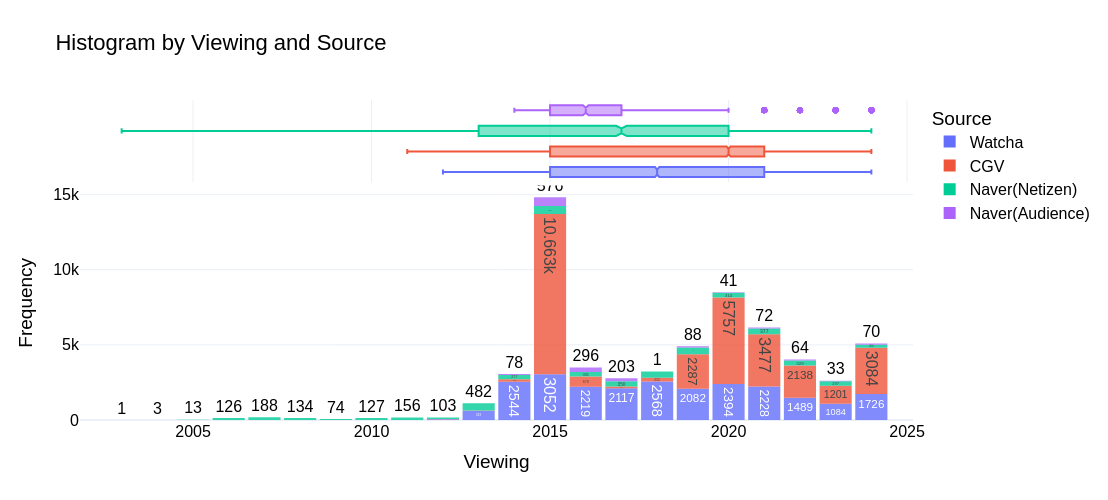

count       mean    std        min        25%        50%  \
Viewing 60,803.0000 2,018.3124 3.4260 2,003.0000 2,015.0000 2,019.0000   

               75%        max  
Viewing 2,021.0000 2,024.0000

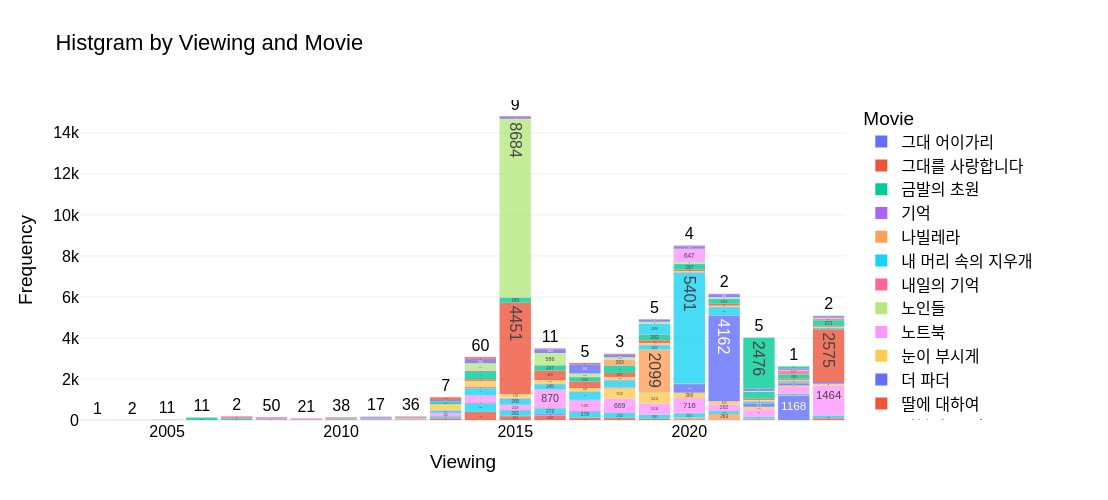

In [42]:
# 데이터 추세
## 연도별(리뷰) 소스별 리뷰의견수 추세
plot_histogram(df_freq, x='Viewing', color='Source', title='Histogram by Viewing and Source', marginal='box')
## 연도별(리뷰) 영화별 리뷰의견수 추세
plot_histogram(df_freq, x='Viewing', color='Movie', title='Histgram by Viewing and Movie')

count   mean     std    min    25%    50%    75%      max
Length 60,803.0000 6.6606 12.6072 1.0000 3.0000 4.0000 7.0000 952.0000

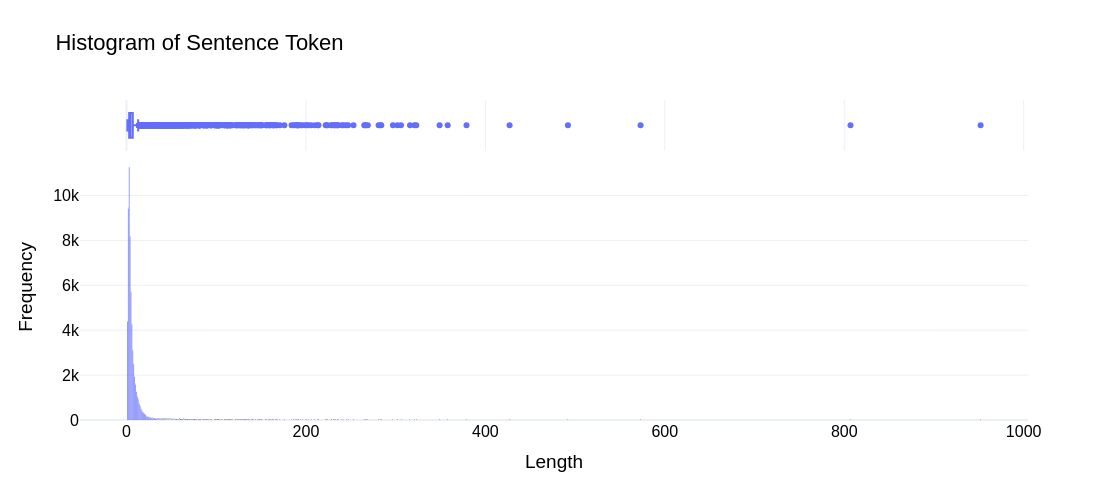

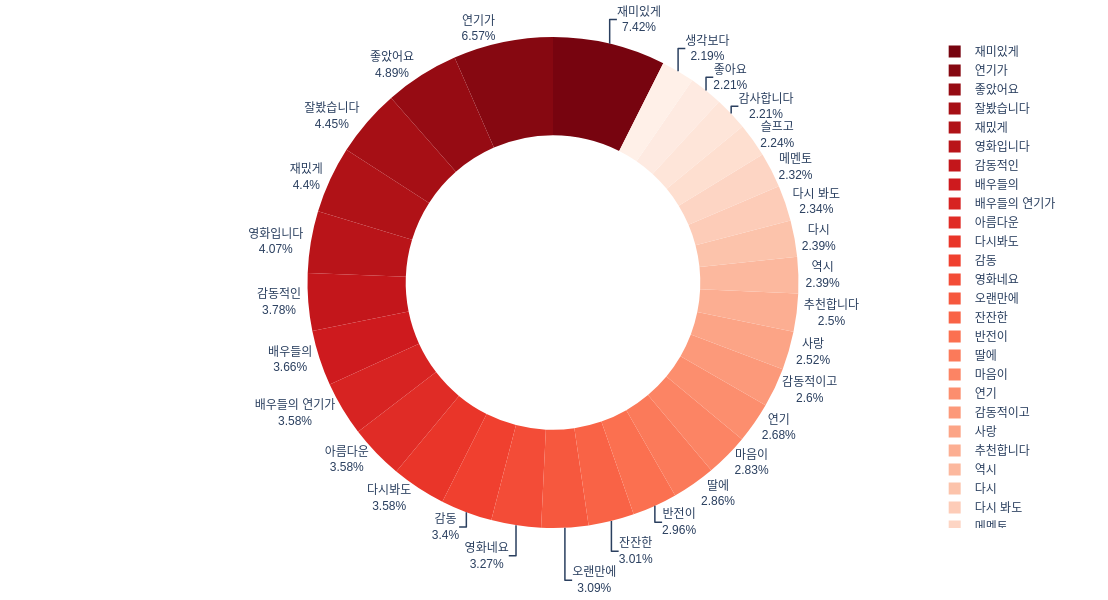

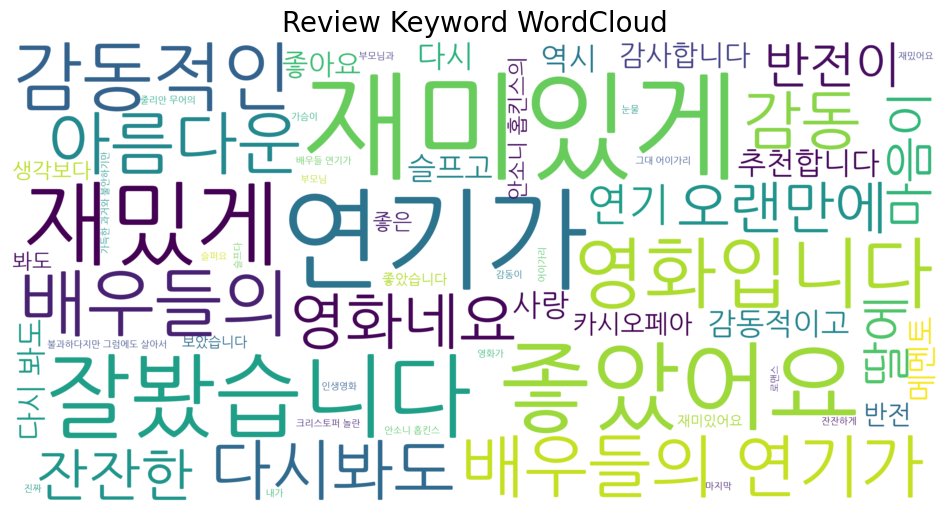

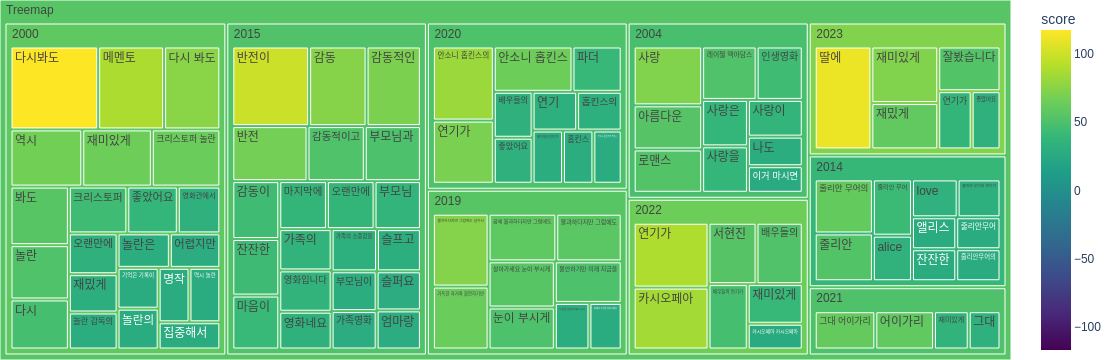

In [43]:
# 키워드 분포
## 리뷰문장 토큰 길이 분포
plot_histogram_senttoken(df_freq['Token_'+TOKENIZER]) 
## 전체기간 주요키워드 분포
plot_donut_wordfreq(word_freq)
plot_wordcloud(word_freq, title='Review Keyword WordCloud', max_font_size=50, save_local=False)
## 연도별(리뷰) 주요키워드 분포
plot_treemap_wordfreq(word_freq_categ)

2025-02-07 00:02:18,674	INFO worker.py:1777 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Optimal Topic Number:  2


[Kss]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


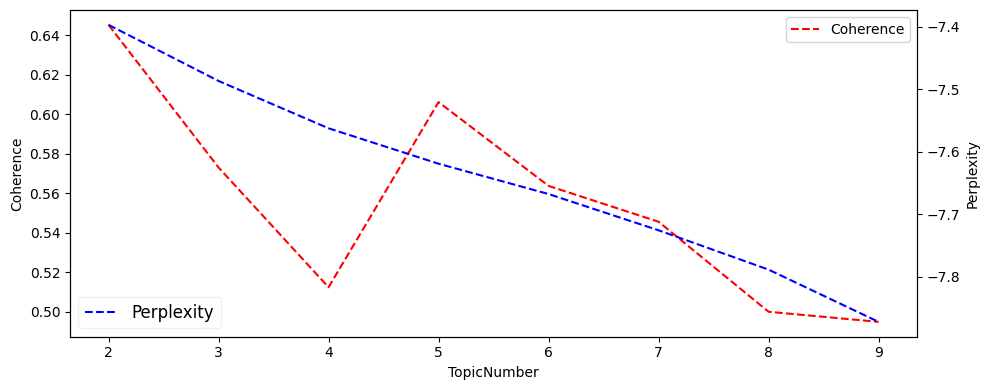

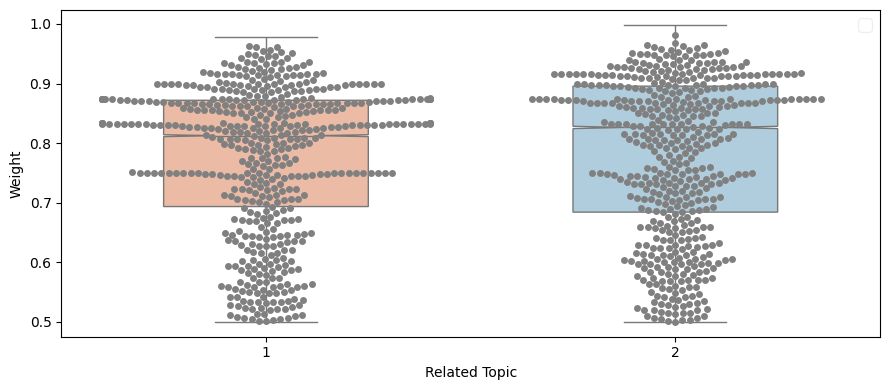

Related Keywords  \
Topic 1  '연기(22.5%)', '감동(20.2%)', '눈물(11.0%)', '서현진(9.2%)', '연기가(8.7%)', '반전(8.1%)', '진짜(5.8%)', '좋은(5.2...   
Topic 2  '사랑(28.6%)', '가족(11.1%)', '치매(9.5%)', '이야기(8.7%)', '지는(7.9%)', '기억(7.1%)', '가는(7.1%)', '마음(7.1%)...   

         Number of Sentences  Percentage  Average Probability  
Topic 1                30987      0.5096               0.7731  
Topic 2                29816      0.4904               0.7854

In [30]:
# 주요토픽 트랜드
## 원래의견 기준 LDA 최적화
save_name = SAVE_NAME_LDA.split('.')[0]+'_CommentPrepAuto(1,3)_Topic{}.xlsx'.format(NUM_TOPIC)

topic_kw_LDA, topic_doc_LDA, \
doc_topic_LDA, model_LDA = modeling_LDA(df_freq['Token_'+TOKENIZER], df_freq['Comment_Prep'],
                                        num_topics=NUM_TOPIC, num_topicwords=NUM_TOPICWORDS, num_topicsamples=NUM_TOPICSAMPLES,
                                        save_local=SAVE_LOCAL, save_name=save_name)
display(topic_kw_LDA)

[Kss]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


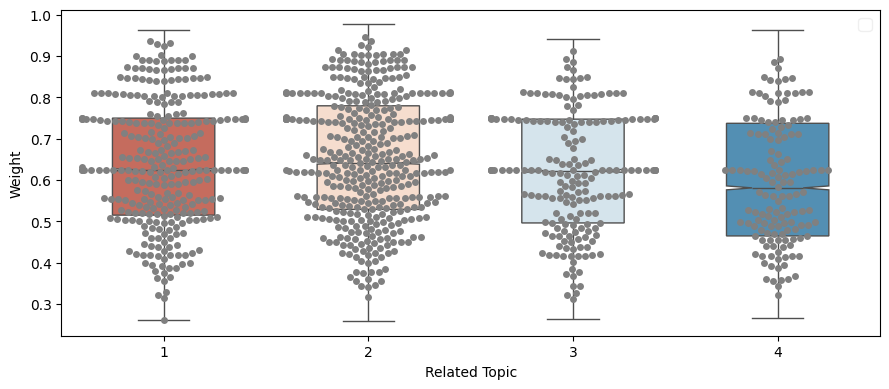

Related Keywords  \
Topic 1  '연기(28.3%)', '서현진(10.1%)', '눈물(9.4%)', '연기가(8.2%)', '최고(8.2%)', '진짜(7.5%)', '좋은(7.5%)', '좋았어요(7....   
Topic 2  '사랑(27.9%)', '가족(11.7%)', '치매(9.7%)', '이야기(9.1%)', '기억(8.4%)', '지는(7.8%)', '가는(7.1%)', '알츠하이머(6....   
Topic 3  '감동(37.3%)', '연기(10.4%)', '엄마(10.0%)', '눈물(9.6%)', '반전(8.5%)', '연기가(6.5%)', '좋았습니다(5.0%)', '영화입니...   
Topic 4  '남자(13.0%)', '카시오페아(13.0%)', '사랑(13.0%)', '말이(9.8%)', '슬퍼요(9.8%)', '인생(8.7%)', '여자(8.7%)', '내가(8...   

         Number of Sentences  Percentage  Average Probability  
Topic 1                19277      0.3170               0.6501  
Topic 2                21682      0.3566               0.6353  
Topic 3                11825      0.1945               0.6162  
Topic 4                 8019      0.1319               0.5916

Topic Number  Weight  \
46694      Topic 1  0.9643   
4026       Topic 1  0.9602   
54651      Topic 1  0.9567   
4426       Topic 1  0.9546   
60531      Topic 1  0.9542   
13271      Topic 2  0.9766   
10484      Topic 2  0.9732   
42575      Topic 2  0.9696   
3661       Topic 2  0.9690   
37284      Topic 2  0.9679   
3493       Topic 3  0.9408   
1653       Topic 3  0.9378   
36013      Topic 3  0.9305   
49786      Topic 3  0.9229   
35436      Topic 3  0.9213   
35240      Topic 4  0.9624   
10696      Topic 4  0.9518   
7194       Topic 4  0.9460   
12158      Topic 4  0.9388   
8599       Topic 4  0.9317   

                                                                                              Comment_Prep  
46694  비슷한 영화를 봐서 스토리에 기대감 없이 봐서 그런지 좋았다 생각지도 못한 스토리여서 놀랐고 오랫만에 부모님 생각 특히 아빠 생각이 나는 영화였다 첫 장면 시골 버스와 들꽃...  
4026   20221106 이제야 본   지금도 예쁘지만 손예진님 앳되고 예쁘다  오랜만에 보면서 눈물  어릴 보기보다 지금 봐서 그시절의 감성과 나보다 어린 나이의 손예진님을 보면서...  
54651  추석특선영화로 봤는데 내용 뻔히 알고봤음에도 막판에 눈물남 아직 증인정우성 주연남았는데 현재로썬 올 추석연휴 최고의영화 영화내내 잔잔하다가 막판에 막 감성자극함 끝장연도 그...  
4426   2000년대 로맨스 특유의 잔잔하면서 오래된 느낌이 편안하면서 그립게 만든다 보면 오글거리는 대사인데 울컥하는건 연핑크빛 하늘색과 피아노 배경음악때문인지 배우들 연기때문인지...  
60531             초중반까지는 스토리 연출 연기까지 훌륭했지만 후반부 부터는 루즈 해지는 느낌이 있어서 아쉬웠다 마지막 엔딩에서 카메라를 줌 아웃해서 마무리하는 장면은 훌륭했다  
13271  평상시에 느끼지 못하지만 삶에 강렬히 존재하는 중력과도 같은 시간의 무게감을 느꼈다 노화에 이야기의 비중이 크지만 시청자의 연령대와 상관없이 묵묵히 각자의 삶을 살아가고 인...  
10484  내 사랑 앨리에게 사이가 끝났다고 생각하니 잠이 안왔어 진실한 사랑을 했으니 씁쓸할 건 없어 미래에 먼발치에서 서로의 새 인생을 보면 기쁨으로 미소 짓겠지 여름 나무 아래서...  
42575  영화가 아름다우면 아름다울수록 우리의 현실은 고통과 더러운 모습을 자랑하고 있겠지 삶의 고통 자체가 아름답지는 않을 거다 받아들이고 해석하느냐에 속에 아름다움을 볼 있을까 ...  
3661   누군가를 간절하게 사랑할수있을까  마지막씬에 낡은 지프차를 타고 어디론가 향할때   남자주인공의 사랑해  세상에서 가장 행복한 모습으로 포옹하는 그녀의 모습   형식도 틀도...  
37284  결국엔 남는 건 사랑뿐이다 기억이 지워지더라도 사랑은 지워지지 않는다 지금의 나는 수많은 기억들의 집합체라 하겠지만 어쩌면 지금의 나를 사랑해주는 사람들 내가 사랑하는 사람...  
3493                                             초반에 레이첼 맥아담스 마냥 사랑스러운 손예진이었고 후반엔 줄리엔 무어의 앨리스 연기에 다시금 감탄했다  
1653                   이깊은 곳에서 우러나오는 진한 이순재의 연기는 이들을 눈물을 자아내게 했다 김만석을 그대로 받아드린 연기 만화와 비교해도 떨어지지 않는 작품성과 감동  
36013                                                     배우들의 연기력이 좋다 줄리안 무어의 연기력에 감탄하고 크리스틴 스튜어트 연기에 놀랬다  
49786                                                          찬열이 보러갔다가 웃음 감동 감동 감동 얻고 왔다 진짜 반전에 반전을 거듭한다  
35436                                                                 줄리안 무어는 진짜 연기를 잘하는 배우다 아낌없이 보여줘서 감사한  
35240  rail able remember things moments day pure happiness joy think suffering suffering struggling st...  
10696  ill smile joy remember spent summer beneath trees learning growing love best love kind awakens s...  
7194   youre bird im bird listen heart left  right best love kind awakens soul makes reach plants fire ...  
12158  약혼남이 주인공이었다면 반응들이 나왔을지 궁금하다 여자의 마음은 갈대라고 앨리의 마음은 갈대가 아니라 하늘을 나는 비닐봉다리를 연상시킨다 흔들리는것도 유분수지 어장관리도 아...  
8599   1 allie dont leave wait minute breaking come fight tomorrow like happend right  2 noah gonna eas...

In [31]:
## 원래의견 기준 LDA 최종
NUM_TOPIC_FINAL = 4
save_name = SAVE_NAME_LDA.split('.')[0]+'_CommentPrepAuto(1,3)_Topic{}.xlsx'.format(NUM_TOPIC_FINAL)

topic_kw_LDA, topic_doc_LDA, \
doc_topic_LDA, model_LDA = modeling_LDA(df_freq['Token_'+TOKENIZER], df_freq['Comment_Prep'],
                                        num_topics=NUM_TOPIC_FINAL, num_topicwords=NUM_TOPICWORDS, num_topicsamples=NUM_TOPICSAMPLES,
                                        save_local=SAVE_LOCAL, save_name=save_name)
display(topic_kw_LDA, topic_doc_LDA)

In [ ]:
# ## 토픽별 워드클라우드
# word_freq_topic, wordadj_freq_topic, df_freq_topic = preprocessing_wordfreq(doc_topic_LDA, 
#                                                                             colname_target=TARGET+'_Prep', colname_category='Related Topic', 
#                                                                             ngram_range=NGRAM_RANGE,
#                                                                             tfidf_maxcol=TFIDF_MAXCOL, tfidf_dellowfreq=TFIDF_DELLOWFREQ,
#                                                                             keybert_topnkwd=KEYBERT_TOPNKWD,
#                                                                             sent2kwd_ray=RAY,
#                                                                             num_showkeyword=NUM_SHOWKEYWORD, 
#                                                                             save_local=SAVE_LOCAL, save_name=SAVE_NAME_PREP+'topic')

# for group in word_freq_topic[TOKENIZER]['category'].unique():
#     df_sub = word_freq_topic[word_freq_topic[TOKENIZER]['category'] == group]
#     plot_wordcloud(df_sub, title='Topic_'+str(group), max_font_size=50, save_local=False)

In [46]:
# 데이터결합: 원본+감성분석+토픽결과
df_freq_topic = pd.concat([df_freq, doc_topic_LDA.iloc[:,1:]], axis=1)

In [53]:
## 영화별 토픽 분포
df_topic_ratio, _ = LDA_resultstat(df_freq_topic, 'Movie', 'Related Topic', colname_prefix='Topic')

Topic Rank
Movie                         
그대 어이가리          3 > 2 > 1 > 4
그대를 사랑합니다        2 > 1 > 3 > 4
금발의 초원           2 > 1 > 4 > 3
기억               1 > 2 > 3 > 4
나빌레라             2 > 1 > 4 > 3
내 머리 속의 지우개      1 > 2 > 4 > 3
내일의 기억           2 > 1 > 3 > 4
노인들              2 > 4 > 3 > 1
노트북              2 > 1 > 4 > 3
눈이 부시게           2 > 1 > 4 > 3
더 파더             2 > 1 > 3 > 4
딸에 대하여           2 > 1 > 3 > 4
러블리, 스틸          2 > 1 > 3 > 4
레저 시커            2 > 4 > 1 > 3
로망               1 > 3 > 2 > 4
메멘토              1 > 2 > 4 > 3
사랑의 기적           2 > 1 > 3 > 4
살인자의 기억_복수       2 > 1 > 4 > 3
세비지스             2 > 1 > 4 > 3
세상에서 가장 아름다운 이별  1 > 2 > 3 > 4
소중한 사람           2 > 1 > 3 > 4
스틸 앨리스           2 > 3 > 1 > 4
시                2 > 4 > 1 > 3
어웨이 프롬 허         2 > 1 > 4 > 3
엄마의 공책           2 > 3 > 1 > 4
왓 데이 해드          2 > 1 > 3 > 4
이터널 메모리          2 > 1 > 4 > 3
장수상회             1 > 3 > 2 > 4
조금씩, 천천히 안녕      2 > 1 > 3 > 4
천일의 약속           1 > 2 > 4 > 3
첫 키스만 50번째       2 > 1 > 4 > 3
친정엄마             1 > 3 > 2 > 4
카시오페아            1 > 2 > 3 > 4
해피엔딩 프로젝트        2 > 4 > 1 > 3

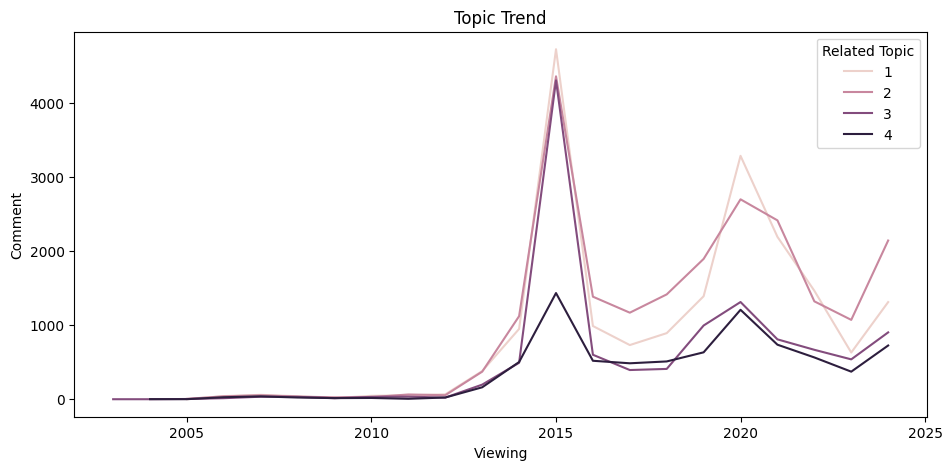

In [51]:
## 토픽 Hot & Cold 리뷰 트랜드
df_plot = df_freq_topic.groupby(['Viewing', 'Related Topic'])['Comment'].count().reset_index()
fig = plt.figure(figsize=(11, 5))
sns.lineplot(df_plot, x='Viewing', y='Comment', hue='Related Topic')
plt.title('Topic Trend')
plt.show()
# ## 토픽 Hot & Cold 확률분포 트랜드
# df_plot = df_freq_topic.groupby(['Viewing', 'Related Topic'])['Weight'].mean().reset_index()
# fig = plt.figure(figsize=(11, 5))
# sns.lineplot(df_plot, x='Viewing', y='Weight', hue='Related Topic')
# plt.title('Topic Trend')
# plt.show()

In [55]:
# 주요토픽별 감성(Rating) 트랜드
## 영화별 감성 분포
df_rating_binary_ratio, _ = LDA_resultstat(df_freq_topic, 'Movie', 'Rating_Binary', colname_prefix='Rating')

Rating Rank
Movie                      
그대 어이가리              1 > -1
그대를 사랑합니다            1 > -1
금발의 초원               1 > -1
기억                   -1 > 1
나빌레라                 -1 > 1
내 머리 속의 지우개          -1 > 1
내일의 기억               1 > -1
노인들                  -1 > 1
노트북                  -1 > 1
눈이 부시게               -1 > 1
더 파더                 1 > -1
딸에 대하여               1 > -1
러블리, 스틸              1 > -1
레저 시커                -1 > 1
로망                   1 > -1
메멘토                  1 > -1
사랑의 기적               1 > -1
살인자의 기억_복수           -1 > 1
세비지스                 -1 > 1
세상에서 가장 아름다운 이별      1 > -1
소중한 사람               1 > -1
스틸 앨리스               1 > -1
시                    1 > -1
어웨이 프롬 허             1 > -1
엄마의 공책               1 > -1
왓 데이 해드              1 > -1
이터널 메모리              1 > -1
장수상회                 1 > -1
조금씩, 천천히 안녕          1 > -1
천일의 약속               -1 > 1
첫 키스만 50번째           1 > -1
친정엄마                 1 > -1
카시오페아                1 > -1
해피엔딩 프로젝트            1 > -1

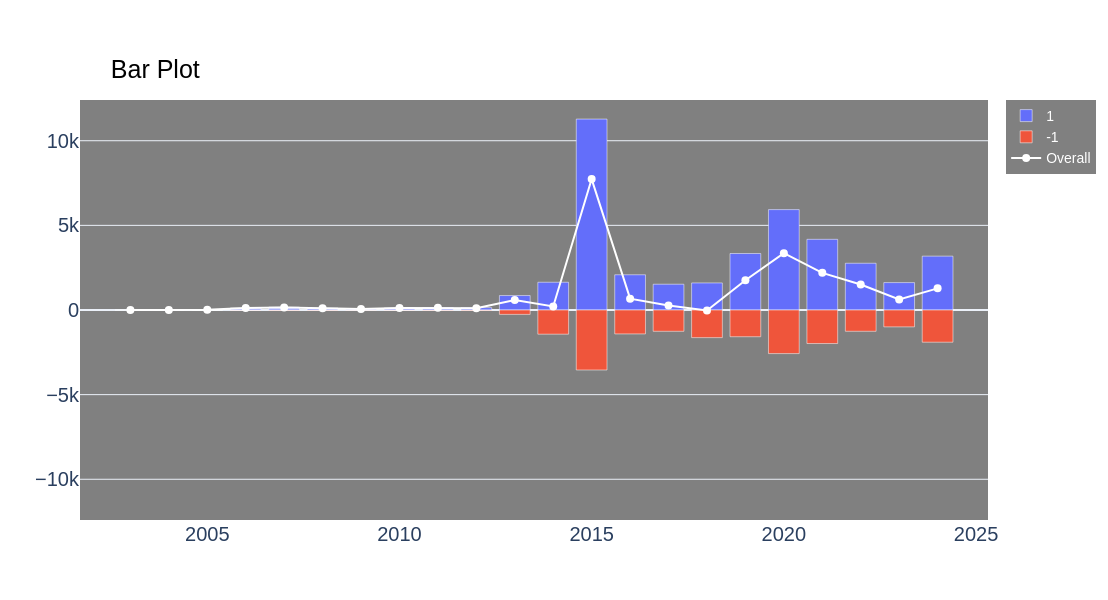

In [58]:
## 연도별 감성 긍부정 트랜드
df_sent_time = df_freq_topic.groupby('Viewing')[['Rating_Binary']].value_counts().unstack()
df_sent_time = df_sent_time[[1,-1]]
df_sent_time.iloc[:,1] = df_sent_time.iloc[:,1] * -1
plot_bar(df_sent_time, summation=True, save_local=False)

1


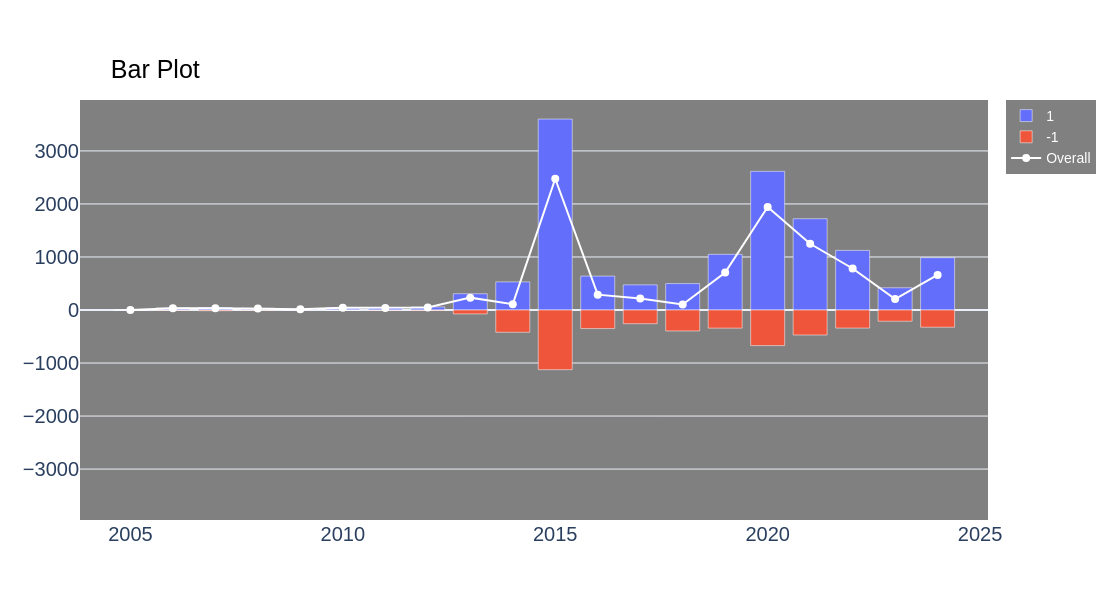

2


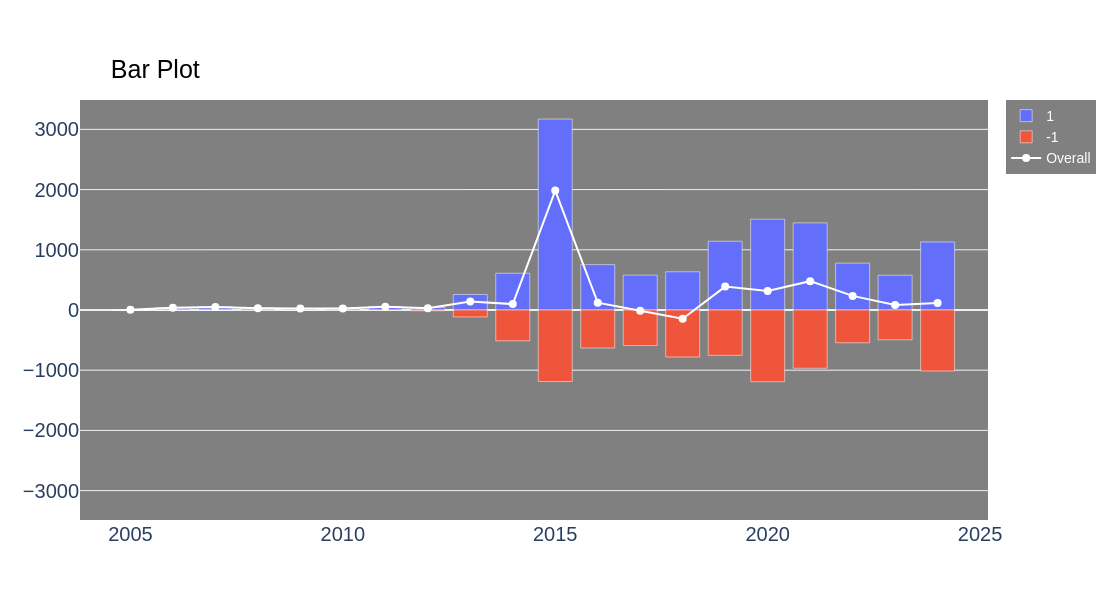

3


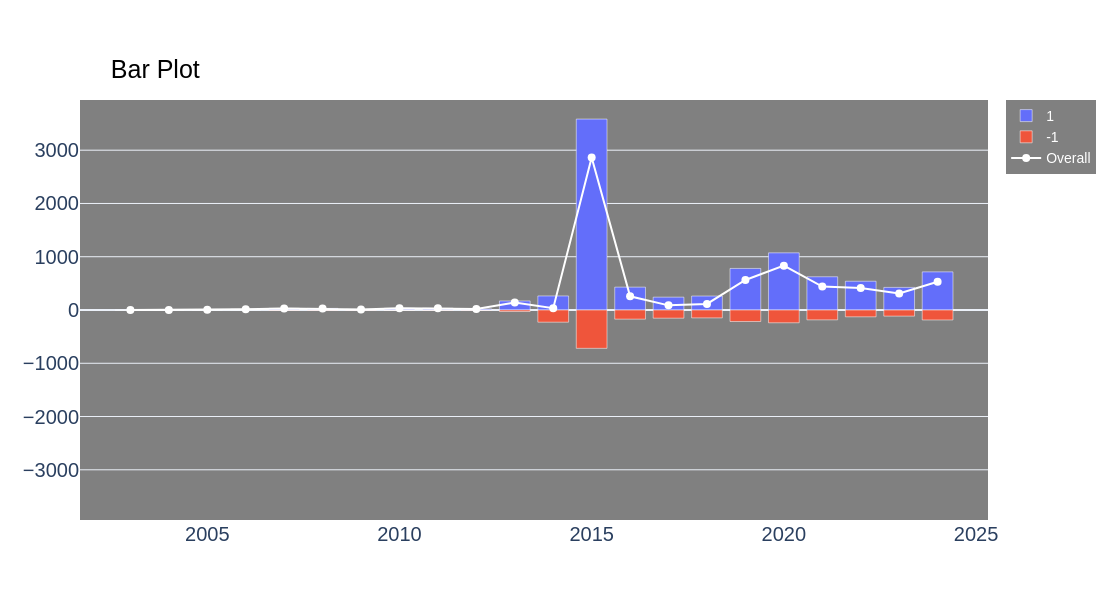

4


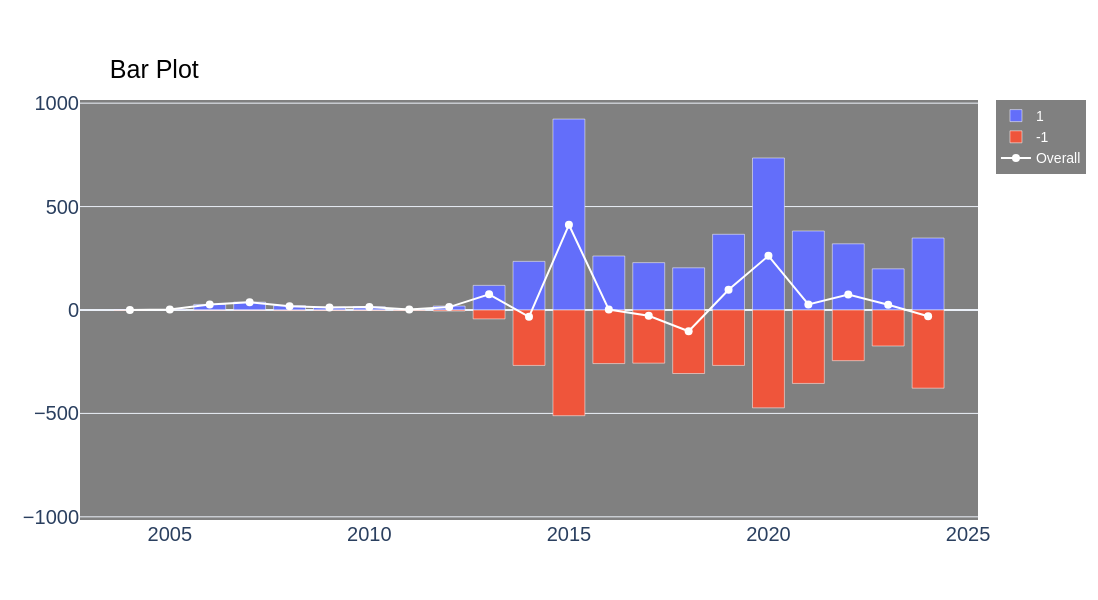

In [59]:
## 토픽별 감성 긍부정 트랜드
for topic in sorted(df_freq_topic['Related Topic'].unique()):
    print(topic)
    df_sub = df_freq_topic[df_freq_topic['Related Topic'] == topic].reset_index().iloc[:,1:]
    df_sub_time = df_sub[df_sub.Rating_Binary != 0].groupby('Viewing')[['Rating_Binary']].value_counts().unstack()
    df_sub_time = df_sub_time[[1,-1]]
    df_sub_time.iloc[:,1] = df_sub_time.iloc[:,1] * -1
    plot_bar(df_sub_time, summation=True, save_local=False)

# Others

In [67]:
## 치매 주제의 평점 긍부정 트랜드
movie_filter_num = 1
for topic in sorted(df_freq_topic['Related Topic'].unique()):
    if topic == 2:
        df_sub = df_freq_topic[df_freq_topic['Related Topic'] == topic].reset_index().iloc[:,1:]
        df_group = df_sub[df_sub.Rating_Binary != 0].groupby(['Movie'])[['Rating_Binary']].sum()
        movie_posi = list(df_group[df_group>=0].dropna().index)
        movie_nega = list(df_group[df_group<0].dropna().index)
        display(df_group.loc[movie_posi,:].sort_values(by='Rating_Binary', ascending=False).T)
        display(df_group.loc[movie_nega,:].sort_values(by='Rating_Binary', ascending=False).T)
        movie_posi = list(df_group.loc[movie_posi,:].sort_values(by='Rating_Binary', ascending=False).index[:movie_filter_num])
        movie_nega = list(df_group.loc[movie_nega,:].sort_values(by='Rating_Binary', ascending=False).index[-movie_filter_num:])
        print(movie_posi, movie_nega)

Movie          장수상회  스틸 앨리스  메멘토  더 파더   로망  카시오페아    시  그대 어이가리  딸에 대하여  \
Rating_Binary  1029     820  713   599  431    363  299      185     182   

Movie          왓 데이 해드  조금씩, 천천히 안녕  금발의 초원  내일의 기억  친정엄마  그대를 사랑합니다  사랑의 기적  \
Rating_Binary      127           79      71      52    51         47      46   

Movie          세상에서 가장 아름다운 이별  엄마의 공책  해피엔딩 프로젝트  소중한 사람  이터널 메모리  어웨이 프롬 허  \
Rating_Binary               38      33         24      23       16        13   

Movie          기억  러블리, 스틸  
Rating_Binary   9        7

Movie          세비지스  레저 시커  천일의 약속  노인들  살인자의 기억_복수  나빌레라  첫 키스만 50번째  \
Rating_Binary    -3     -6      -6   -7          -7   -35         -48   

Movie          내 머리 속의 지우개  눈이 부시게  노트북  
Rating_Binary         -193    -354 -544

['장수상회'] ['노트북']


In [71]:
## 감성에 따른 데이터분리
df_freq_topic_posi = df_freq_topic[df_freq_topic.Movie.isin(movie_posi)]
df_freq_topic_posi = df_freq_topic_posi[df_freq_topic_posi.Rating_Binary == 1].reset_index().iloc[:,1:]
df_freq_topic_nega = df_freq_topic[df_freq_topic.Movie.isin(movie_nega)]
df_freq_topic_nega = df_freq_topic_nega[df_freq_topic_nega.Rating_Binary == -1].reset_index().iloc[:,1:]

[Kss]: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
[Kss]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


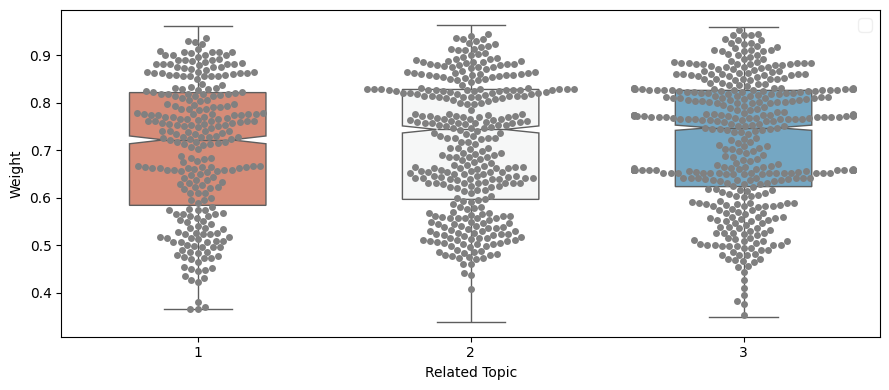

Related Keywords  \
Topic 1  '감동(15.7%)', '연기(15.7%)', '눈물(13.8%)', '진짜(12.6%)', '스토리(8.2%)', '가슴(7.5%)', '반전(7.5%)', '마음이(6....   
Topic 2  '사랑(20.0%)', '반전이(12.5%)', '가족(10.6%)', '좋은(10.6%)', '보면(10.0%)', '부모님(9.4%)', '가슴(8.1%)', '펑펑(6...   
Topic 3  '감동(40.2%)', '반전(15.2%)', '눈물(9.8%)', '부모님(8.7%)', '마지막(6.1%)', '사랑(4.2%)', '재미(4.2%)', '생각(4.2%...   

         Number of Sentences  Percentage  Average Probability  
Topic 1                 2061      0.2639               0.7178  
Topic 2                 2401      0.3074               0.7119  
Topic 3                 3349      0.4288               0.7016

Topic Number  Weight  \
1222      Topic 1  0.9617   
7426      Topic 1  0.9590   
167       Topic 1  0.9585   
109       Topic 1  0.9563   
7461      Topic 1  0.9558   
951       Topic 2  0.9639   
41        Topic 2  0.9614   
495       Topic 2  0.9601   
3340      Topic 2  0.9598   
5298      Topic 2  0.9594   
5491      Topic 3  0.9591   
6077      Topic 3  0.9536   
2418      Topic 3  0.9533   
7773      Topic 3  0.9506   
2267      Topic 3  0.9484   

                                                                                                  Comment  
1222  반전을 예상하고 본 영화.\r\n뻔히 알면서 눈물이 멈추지 않음.\r\n어벤져스보다 역대급 영화.\r\n어벤져스가 아니였다면 500만 관객도\r\n무리 없는 배우들의 연기와...  
7426  추석특선영화로 봤는데 내용 뻔히 알고봤음에도 막판에 눈물남 아직 증인(정우성 주연)남았는데 현재로썬 올 추석연휴 최고의영화 영화내내 잔잔하다가 막판에 막 감성자극함 끝장연도...  
167   초반부의 어색한 전개를 극복하는 중반부를 넘어서 후반부로 가면 어느 새 영화에 빠져들어있는 나를 보게되는 영화. 배우들의 연기력은 감독과 작가의 약한 기획력을 충분히 커버하...  
109   요며칠 오래된 아파트가 건조해 힘들었는데 오늘 내 콧속에 있던 모든 것들이 휴지를 통해 탈출하고 콧속이 촉촉해졌다. 이게 얼마만의 편안함인지 영화의 순기능 땡큐.  연기는 ...  
7461  평점리뷰를 대강 읽어본 후 가서 보았는데, 한참 웃다가 어느새 뚝뚝 눈물을 흘리고 있는 나를 발견했다. 함께 영화를본 50대 중반의 우리 엄마는 근래들어(국제시장보다 더) ...  
951   사실 엑소 찬열이 나온다거 해서 본 영화였지만 영화를 보면서 가족들과 함께 보았으면 정말 좋았을 영화라고 생각했다. 배우님들의 연기도 최고였으며 마지막 반전도 최고였다. 영...  
41    주연 배우들의 압도적인 연기도 조역들의 감칠맛 나는 연기도 기본 소재와 플롯도 훌륭한데 이걸로 이런 영화 밖에 만들 수 없다니... 이 영화의 클라이맥스가 왜 "재개발 확정...  
495   너무 좋은 영화입니다~\r\n다시한번 가족의 소중함을 일깨워주는 영화네요~  가장을 아끼는 마음 온 가족이 치매걸린 아버지를 돕는 영화 오랜만에 남편과 좋은 영화본것 같아서...  
3340  새끼(자식)는 부모의 가슴 한켠에 돌뎅이처럼 자리잡고 있다고 했다. 자식된 도리를 얼마나 하고있는건지 생각하게 만드는 영화. 중반부터 눈물이 계속 흘렀다. 기가막힌 반전에 ...  
5298  일욜오전 고딩.초딩아들과 이영화보고  고딩.초딩아들의  눈시울을 적시는  따뜻한영화 친정엄마와친구분께 모바일티켓으로  장수상회 영화를 선물해드렸다   가족영화가 많아지길 바...  
5491  따뜻한영화이다 . 그냥 영화는 느끼는 감정그대로가 좋은게 좋다 꼭 요즘 영화는 ~다하는 식의 흑백논리적 사고는 옳지않다는 생각이든다. 어르신들의 아름다운 사랑 그리고 그들도...  
6077                                  어제 봤는데 적당한 웃음도 있고 잔잔한 감동도 있고 좋은 영화였습니다. 부모님의 존재에 대해 다시 한번 생각해보게 되네요  
2418  반전이 짱인 영화, 코믹영화인줄알고 봤는데 눈물 줄줄줄ㅠ. ㅠ\r\n우리 외할머니 생각도 나고ㅠㅠ\r\n그리고 출연진들이 전부 연기력 빵빵하신 분들!\r\n깨알같은 코믹장면...  
7773                    반전도 있고 감동도 있고. 영화 보는 내내 부모님 생각이 나더군요.  저는 재밌게 봐서 별 후하게 드리겠습니다! 잔잔한 감동과 재미가 있는 영화~  
2267  처음에는 동네마을에서 살아가는 사람들에 이야기이며 개발지역으로 만들기위해 협동하나부다~  대충 그렇게 생각하면서 보는데..... 마지막쯤에 그런반전이 있을줄이야!!!!\r\...

[Kss]: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
[Kss]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


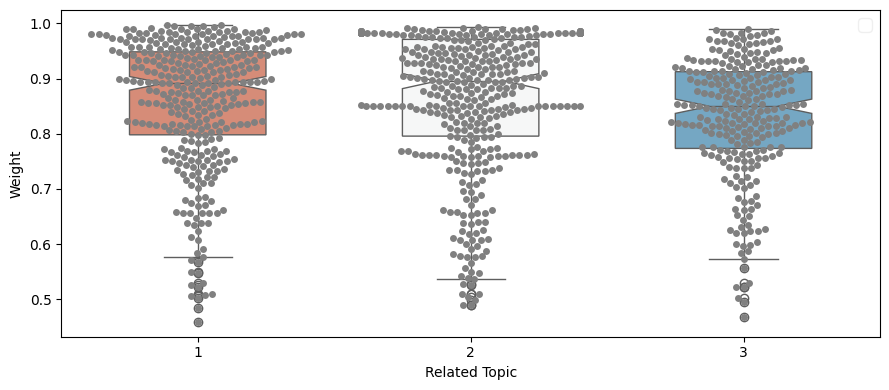

Related Keywords  \
Topic 1  '드라마(24.6%)', '있습니다(10.0%)', '눈이(10.0%)', '지금(9.2%)', '인생(9.2%)', '않은(8.5%)', '부시게(7.7%)', '나는(6...   
Topic 2  '눈이(15.1%)', '지금(12.7%)', '있습니다(11.4%)', '자격이(9.6%)', '부시게(9.0%)', '드라마(9.0%)', '오늘을(8.4%)', '당신...   
Topic 3  '눈이(18.4%)', '부시게(14.7%)', '인생(11.8%)', '드라마(9.6%)', '삶이(8.8%)', '있습니다(8.8%)', '모든(7.4%)', '않은(7...   

         Number of Sentences  Percentage  Average Probability  
Topic 1                  363      0.3431               0.8604  
Topic 2                  412      0.3894               0.8565  
Topic 3                  283      0.2675               0.8296

Topic Number  Weight  \
403       Topic 1  0.9973   
71        Topic 1  0.9971   
830       Topic 1  0.9957   
605       Topic 1  0.9949   
13        Topic 1  0.9948   
106       Topic 2  0.9934   
1024      Topic 2  0.9922   
770       Topic 2  0.9916   
702       Topic 2  0.9911   
90        Topic 2  0.9906   
774       Topic 3  0.9890   
1055      Topic 3  0.9873   
286       Topic 3  0.9854   
62        Topic 3  0.9834   
478       Topic 3  0.9830   

                                                                                                  Comment  
403   1. 너무 슬프다. 이 드라마를 본 것이 잘한 건가 싶을 만큼 혜자와 준하, 아들 내상의 인생이 너무 슬프다. 어떻게 이런 삶..어찌 이런 삶..이건 너무 가혹하지...내가...  
71    이 드라마를 보게 된 것은 순전히 백상예술대상을 보고서였다. 드라마를 보기 전에는 한지민의 미래가 김혜자고 한지민은 과거회상 정도겠거니 혹은 과거로 돌아간 모습이 한지민이겠...  
830   많이 울었다. 하루하루 생기있는 젊은 날과 어떤 색으로도 칠해지지 않을 수도 있을 늙은 시간이 한 장면에 있다는 게 먹먹해서. 꿈을 꾸는 게 젊은 나인지 늙은 나인지가 헷갈...  
605   [이 드라마는 끝까지 본 사람에게는 명작일 수밖에 없을 것]  이 드라마의 내용을 완전히 이해하기 전에 느꼈던 감정은 낯섦이었다. 한국 드라마에서 시계와 같은 도구를 써서 ...  
13    치매를 새로운 시점에서 바라본 웰메이드 명품 드라마 <시간 이동>  사실 이 모든 시간이동 이야기는 서술 트릭으로 나이 든 김혜자는 알츠하이머를 앓고 있었다. 즉 지금까지 ...  
106   근데 난 내가 봐도 그 정도는 아니야. 좀 후져... 근데 또 그걸 막 인정하는게 너무 힘들어. 왜? 나는, 내가 너무 애틋하거든. 나란 애가 제발 좀 잘 됐으면 좋겠는데,...  
1024  와닿았던  대사들 몇가지. . 1. 면접볼 때도 면접관이 나한테도 물어보긴 하는데 이게 예의상 물어보는건지 아닌지 알겠더라고. 대단한 애들한테는 일단 웃어. 걔네가 뭔 얘기...  
770   젊은 내가 늙은 꿈을 꾸는건지 늙은 내가 젊은 꿈을 꾸는건지  나의 인생이 불행했다고 생각했습니다 억울하다고 생각했습니다 그런데 지금 생각해보니 당신과 행복했던 기억부터 불...  
702   잘난 거랑 잘사는 거랑 다른 게 뭔지 알아? 못난 놈이라도 잘난 것들 사이에 비집고 들어가서 “나 여기 살아있다. 나 보고 다른 못난 것들 힘내라” 이러는 게 진짜 잘사는 ...  
90    눈이 부신 그들의 인생에게. - 매 화 눈물을 비추지 않을 수 없었다. 10화는 여러모로 약간 지나치다 생각했는데 아.. 그랬구나. 모든 게 그렇게 되는거였어.  허무하기도...  
774   대사의 티키타카가 재밌다 결말만 알고보니 발랄한 25살의 혜자를 볼때마다 울컥한 느낌  1회 영수 왜케 보잘것 없고 귀엽냐 ㅋㅋㅋ 혜자도 철없이 뽀짝하고 귀여워 ♡ 남주혁 ...  
1055  사람들이 많이 봤으면 좋겠다. 본인이 진실로 원하는 꿈도 아닌데 취업 준비를 하면서 젊음을 보내던 여자주인공이 한순간에 시간을 잃어버린다. 그리고 남자주인공은 하나의 일로 ...  
286   아직 인간은 노화와 죽음을 정복하지 못 했다. 의학의 발전으로 수명은 늘어났을지언정 우리는 모두 죽음이라는 정해진 결말을 피할 수 없다. 우리의 몸은 점점 낡아가고 결국은 ...  
62    빛 바랜 시간 속에서도 한결같이 빛날 모든 사랑과 추억을 예찬하며, 노인의 지나간 세월을 진정성있게 담은 스토리가 효과적인 플롯과 만나 큰 여운을 남긴다. 이걸 보면 모두 ...  
478   +11화까지 리뷰) 나에게, 그리고 사람들에게 흐르는 시간들. 나는 내 시간, 그리고 주변 사람들에게 흐르고 있는 그 눈부신 순간들을 알고 있었나. 지금 그 시간들을 누구와...

In [73]:
## 긍정영화 LDA 주제어
NUM_TOPIC = 3
save_name = SAVE_NAME_LDA.split('.')[0]+'_CommentPrepAuto(1,3)_SentiPosi_Topic{}.xlsx'.format(NUM_TOPIC)

topic_kw_LDA, topic_doc_LDA, \
doc_topic_LDA, model_LDA = modeling_LDA(df_freq_topic_posi['Token_'+TOKENIZER], df_freq_topic_posi['Comment'],
                                        num_topics=NUM_TOPIC, num_topicwords=NUM_TOPICWORDS, num_topicsamples=NUM_TOPICSAMPLES,
                                        save_local=SAVE_LOCAL, save_name=save_name)
display(topic_kw_LDA, topic_doc_LDA)

## 부정영화 LDA 주제어
NUM_TOPIC = 3
save_name = SAVE_NAME_LDA.split('.')[0]+'_CommentPrepAuto(1,3)_SentiNega_Topic{}.xlsx'.format(NUM_TOPIC)

topic_kw_LDA, topic_doc_LDA, \
doc_topic_LDA, model_LDA = modeling_LDA(df_freq_topic_nega['Token_'+TOKENIZER], df_freq_topic_nega['Comment'],
                                        num_topics=NUM_TOPIC, num_topicwords=NUM_TOPICWORDS, num_topicsamples=NUM_TOPICSAMPLES,
                                        save_local=SAVE_LOCAL, save_name=save_name)
display(topic_kw_LDA, topic_doc_LDA)

## BERTopic

In [11]:
# # 원래의견 기준 BERTopic
# save_name = SAVE_NAME_BERTopic.split('.')[0]+'_CommentAuto(1,2).xlsx'
# NUM_TOPICS_BERT = topic_kw_LDA.shape[0]

# topic_kw_BERT, topic_doc_BERT, \
# doc_topic_BERT, model_BERT = modeling_BERTopic(df_freq['Comment'], vectorizer_type='tfidf', 
#                                                ngram_range=NGRAM_RANGE,
#                                                tfidf_maxcol=TFIDF_MAXCOL, 
#                                                # umap_metric=UMAP_METRIC, umap_randomseed=UMAP_SEED,
#                                                num_topics=NUM_TOPICS_BERT, num_topicwords=NUM_TOPICWORDS, num_topicsamples=NUM_TOPICSAMPLES,
#                                                save_local=SAVE_LOCAL, save_name=save_name)
# display(topic_kw_BERT, topic_doc_BERT, doc_topic_BERT)

In [12]:
# # 토픽 유사성 구조 시각화
# model_BERT.visualize_topics()

In [13]:
# # Topic 별 Hierarchy를 출력하여 대략적 Topic의 갯수를 가늠하기 용이함
# model_BERT.visualize_hierarchy(top_n_topics=50)

In [14]:
# # Topic을 대표하는 상위 단어 5개씩 출력
# model_BERT.visualize_barchart(top_n_topics=50)

In [15]:
# # Topic간 유사도를 Cosine Similarity로 계산후 Heatmap으로 표현
# model_BERT.visualize_heatmap()

In [16]:
# # 일자별로 어떤 토픽이 증가하고 줄어들었는지 트랜드 파악
# topics_over_time = model_BERT.topics_over_time(docs=df['Comment'], timestamps=df.Date.to_list(), 
#                                                global_tuning=True, evolution_tuning=True)
# model_BERT.visualize_topics_over_time(topics_over_time, top_n_topics=50)

In [17]:
# # Topic내 대표하는 단어들에 대해서 c-tf-idf로 계산해서 각 단어가 Topic에서 차지하는 중요도를 계산했던 것을 Rank 순서대로 출력
# model_BERT.visualize_term_rank()